# 빌딩 검출

## 파라미터 : 
*  epoch : 30
* beta1: 0.9, beta2 : 0.999 
* learning rate : 0.0001

## 라벨링 방식 : 흑백 채우기 

In [1]:
!pip install wandb

     |████████████████████████████████| 1.8MB 6.5MB/s 
     |████████████████████████████████| 174kB 21.9MB/s 
     |████████████████████████████████| 133kB 21.4MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=e07b6269563399e6d7aa7513612a69c8b91fc7630775ab269ce86eecdd635f83
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=48b194f6d7efd303bf5be409acf51378e56b4c41086f61c4b590a5763d5d1d4d
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [2]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 5.4MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import math
import os
import glob
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import re
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import tensorflow as tf

from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!ls
!ls /content/drive/MyDrive/SIA/colab_code/lhk/

drive  sample_data
 0603_bnr_label01_v1		      aug_test.h5
 0603_bnr_label01_v1.h5		      B_aug_01.h5
 0603_buildings_label01_v1	      BnR_aug_01.h5
 0603_buildings_label01_v1.h5	      BnR_aug_02.h5
 0603_roads_label01_v1		      BnR_aug_activelearning_01.h5
 0603_roads_label01_v1.h5	      bnr_label01_v1.h5
 0605_B_augmentation_01		      BnR_patch_01.h5
 0605_BnR_augmentation_01	      Lv2_BnR_Effb3_FPN
 0605_R_augmentation_01		      Lv2_BnR_Effb3_FPN_Aug_Act
 0606_BnR_imagepatch_01		      Lv2_BnR_Effb3_Linknet_Aug_Act
 0606_R_imagepatch_01		      Lv2_BnR_Effb3_Linknet_Aug_Act.h5
 0612_BnR_augmentation_02	     'Lv2_BnR_Effb7_FPN_아직 안돌림'
 0612_R_augmentation_02		      Lv2_BnR_Res101_Linknet
'0612_R_augmentation_02의 사본'      'Lv2_BnR_Res101_Linknet의 사본'
 0613_BnR_augmentationimagepatch_01  'Lv2_BnR_Res101_Linknet의 사본 (1)'
 0614_roads_patch_v1.h5		      Lv2_BnR_Res101_Linknet.h5
 0618_bnr_effb3_fpn.h5		      R_aug_01.h5
 0618_bnr_resnent50_Linknet.h5	      R_aug_02.h5
 

In [6]:
DATA_DIR =  '/content/drive/MyDrive/SIA/buildings/train/'
VAL_DIR = '/content/drive/MyDrive/SIA/buildings/val/'

In [7]:
B_train_image_path = '/content/drive/MyDrive/SIA/buildings/train/raw_image/' #빌딩 트레인 input image 경로
B_train_label_path = '/content/drive/MyDrive/SIA/buildings/train/new_label/' #빌딩 트레인 변환된 label 경로

B_val_image_path = '/content/drive/MyDrive/SIA/buildings/val/raw_image/' #빌딩 validation input image 경로 
B_val_label_path = '/content/drive/MyDrive/SIA/buildings/val/new_label/' #빌딩 validation 변환된 label image 경로

R_train_image_path = '/content/drive/MyDrive/SIA/roads/train/raw_image/' #도로 트레인 input image 경로 
R_train_label_path = '/content/drive/MyDrive/SIA/roads/train/new_label/' #도로 트레인 변환된 label 경로

R_val_image_path = '/content/drive/MyDrive/SIA/roads/val/raw_image/' #도로 validation input image 경로
R_val_label_path = '/content/drive/MyDrive/SIA/roads/val/new_label/' #도로 트레인 변환된 label 경로 

New_label_path = '/content/drive/MyDrive/SIA/빌딩데이터에도로적용/'      # 새로 만든 도로 라벨 (Lv1 도로모델에서 빌딩 이미지 넣고 에측한거)

In [8]:
BnR_train_png_files = glob.glob(B_train_image_path + '*.png')
B_train_label_png_files = glob.glob(B_train_label_path + '*.png')
R_train_label_png_files = glob.glob(R_train_label_path + '*.png')

BnR_val_png_files = glob.glob(B_val_image_path + '*.png')
B_val_label_png_files = glob.glob(B_val_label_path + '*.png')
R_val_label_png_files = glob.glob(R_val_label_path + '*.png')

R_train_png_files =  glob.glob(R_train_image_path + '*.png')
R_val_png_files =   glob.glob(R_val_image_path + '*.png')

New_label_files =  glob.glob(New_label_path + '*.png')

In [9]:
## lv2 데이터셋의 train과 validation은  기존(lv1)의 train, validation에서 혼합되어 나옴 

## 그러므로 기존 train, validation 명단을 합쳐서 명단을 만들어냄 
BnR_input_png_files = BnR_train_png_files + BnR_val_png_files # 빌딩은 BnR으로 그대로 쓰면됨 
R_input_png_files = R_train_png_files + R_val_png_files

B_label_png_files = B_train_label_png_files + B_val_label_png_files
R_label_png_files = R_train_label_png_files + R_val_label_png_files + New_label_files

# 전체 파일 목록

In [10]:
## 위에서 만든 전체 파일은 train, validation 파일이기때문에 파일의 경로들이 다 다름.
## 이를 해결하기 위해서 파일명만 남기게 함수를 만들어줌 

def file_name_only(files_list):
    filename_only = []
    for i in files_list:
        filename_only.append(i.split('/')[-1])
    return filename_only

In [11]:
BnR_input_png_files_only = file_name_only(BnR_input_png_files)
B_label_png_files_only =file_name_only(B_label_png_files)
R_label_png_files_only = file_name_only(R_label_png_files)

## Lv2 에 쓸 파일 목록명단이랑 체크하기

In [12]:
def check_lv2_list(lv2_list,png_filesname_only,file_path_included):
    lv2 = []
    
    f = open(lv2_list,'r')
    lines = f.readlines()
    for line in lines:
        a = line.split('.')[0] + '.png'
        if a in png_filesname_only:
            ind = png_filesname_only.index(a)
            lv2.append(file_path_included[ind])
    f.close()
    
    return lv2

## Lv2 train

In [13]:
BnR_train_input_list = check_lv2_list("/content/drive/MyDrive/SIA/BnR_train_list.txt",BnR_input_png_files_only,BnR_input_png_files)
Bnr_train_label_list = check_lv2_list("/content/drive/MyDrive/SIA/BnR_train_list.txt",B_label_png_files_only,B_label_png_files)
bnR_train_label_list = check_lv2_list("/content/drive/MyDrive/SIA/BnR_train_list.txt",R_label_png_files_only,R_label_png_files)

## lv2 val

In [14]:
BnR_val_input_list = check_lv2_list("/content/drive/MyDrive/SIA/BnR_val_list.txt",BnR_input_png_files_only,BnR_input_png_files)
Bnr_val_label_list = check_lv2_list("/content/drive/MyDrive/SIA/BnR_val_list.txt",B_label_png_files_only,B_label_png_files)
bnR_val_label_list = check_lv2_list("/content/drive/MyDrive/SIA/BnR_val_list.txt",R_label_png_files_only,R_label_png_files)

# 명단에 들어가는 파일만 체크

In [15]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset_multi:
    CLASSES =  ['roads','buildings']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir_b, 
            masks_dir_r,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [i.split('/')[-1] for i in images_dir]
        self.images_fps = images_dir
        self.masks_fps_b = masks_dir_b
        self.masks_fps_r = masks_dir_r
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_b = cv2.imread(self.masks_fps_b[i], 0)
        mask_r = cv2.imread(self.masks_fps_r[i], 0)
        mask_r = np.where(mask_b != mask_r, mask_r, 0)
        # extract certain classes from mask (e.g. cars)
        mask = np.stack((mask_b,mask_r), axis=-1).astype('float')
        
        # extract certain classes from mask (e.g. cars)
#         masks = [(mask == v) for v in self.class_values]
#         mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            # 둘다 1일 경우..
            background = 255 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
            mask = np.where(mask == 255, mask, 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
#         image = image/255         
        mask = mask/255
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [16]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
       
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [17]:

from albumentations import (
                            Compose,
                            HorizontalFlip,
                            ShiftScaleRotate,
                            OneOf,
                            RandomContrast,
                            RandomGamma,
                            RandomBrightness
   
                            )


def augmentations(prob=0.5):
    
    transformer = Compose([
                      
            HorizontalFlip(p=prob),
            ShiftScaleRotate(p=prob, shift_limit=0.1, scale_limit=.1, rotate_limit=10),
            OneOf([RandomContrast(limit=0.1, p=prob),
                   RandomGamma(gamma_limit=(90, 110), p=prob),
                   RandomBrightness(limit=0.1, p=prob)],p=prob),
            
    ], p=prob)
    return transformer

In [18]:
%env SM_FRAMEWORK=tf.keras

import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [19]:
CLASSES =  ['roads','buildings']

In [20]:
train_dataset = Dataset_multi(
    BnR_train_input_list, 
    Bnr_train_label_list, bnR_train_label_list,
    classes=CLASSES,
    augmentation=augmentations(),
    #preprocessing=get_preprocessing(preprocess_input),
)

In [21]:
valid_dataset = Dataset_multi(
    BnR_val_input_list, 
    Bnr_val_label_list, bnR_val_label_list, 
    classes=CLASSES,    
    augmentation=augmentations(),
   # preprocessing=get_preprocessing(preprocess_input)

)


## 모델 설계

In [22]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 1
LR = 0.001
EPOCHS = 30
preprocess_input = sm.get_preprocessing(BACKBONE)

In [23]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 1s 0us/step


In [24]:
# define optomizer
optim = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [25]:
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [26]:
import wandb
from wandb.keras import WandbCallback
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:
wandb.init(project='segmentation models', entity='https-wandb-ai-jadenmun-res50_unet-workspace-user-jadenmun')

wandb: Currently logged in as: hyunni94 (use `wandb login --relogin` to force relogin)


In [28]:
wandb.config.update({"image_size": 1024, # crop 했을 경우엔 crop 된 size
                     "learning_rate": 0.001, 
                     "batch_size": 1, 
                     "epochs": 30,
                     "backbone": "efficientnetb3", "model" : "FPN",
                     "class": "multi", # ["building", "road", "mixed", "outline"]
                     "preprocess": "none", "augmentation": "applied" , "image_patch": "none"  }) # ["none", "cropped"]
config = wandb.config

In [29]:
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 1024, 1024, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 1024, 1024, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SIA/colab_code/lhk/Lv2_BnR_Effb3_FPN_Aug_Act.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(), WandbCallback()
]

In [30]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7fe29e062f50>>

In [31]:
# earlystopper = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SIA/colab_code/lhk/Lv2_BnR_Effb3_FPN_Aug_Act.h5', verbose=1, save_best_only=True)

# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=30, 
    callbacks=[checkpointer,callbacks],      validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader) ,verbose = 1 
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
324/324 [==============================] - 396s 1s/step - loss: 0.4151 - iou_score: 0.4917 - f1-score: 0.6256 - val_loss: 0.9132 - val_iou_score: 0.3222 - val_f1-score: 0.4477

Epoch 00001: val_loss improved from inf to 0.91320, saving model to /content/drive/MyDrive/SIA/colab_code/lhk/Lv2_BnR_Effb3_FPN_Aug_Act.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
324/324 [==============================] - 218s 671ms/step - loss: 0.3122 - iou_score: 0.5682 - f1-score: 0.6965 - val_loss: 0.3717 - val_iou_score: 0.5431 - val_f1-score: 0.6665

Epoch 00002: val_loss improved from 0.91320 to 0.37170, saving model to /content/drive/MyDrive/SIA/colab_code/lhk/Lv2_BnR_Effb3_FPN_Aug_Act.h5
Epoch 3/30
324/324 [==============================] - 218s 672ms/step - loss: 0.2663 - iou_score: 0.6026 - f1-score: 0.7270 - val_loss: 0.4023 - val_iou_score: 0.5209 - val_f1-score: 0.6394

Epoch 00003: val_loss did not improve from 0.37170
Epoch 4/30
324/324 [==============================] - 217s 671ms/step - loss: 0.2449 - iou_score: 0.6209 - f1-score: 0.7415 - val_loss: 0.4269 - val_iou_score: 0.5143 - val_f1-score: 0.6383

Epoch 00004: val_loss did not improve from 0.37170
Epoch 5/30
324/324 [==============================] - 218s 671ms/step - loss: 0.2218 - iou_score: 0.6368 - f1-score: 0.7565 - val_loss: 0.3222 - val_iou_score: 0.5731 - val_f1-score:

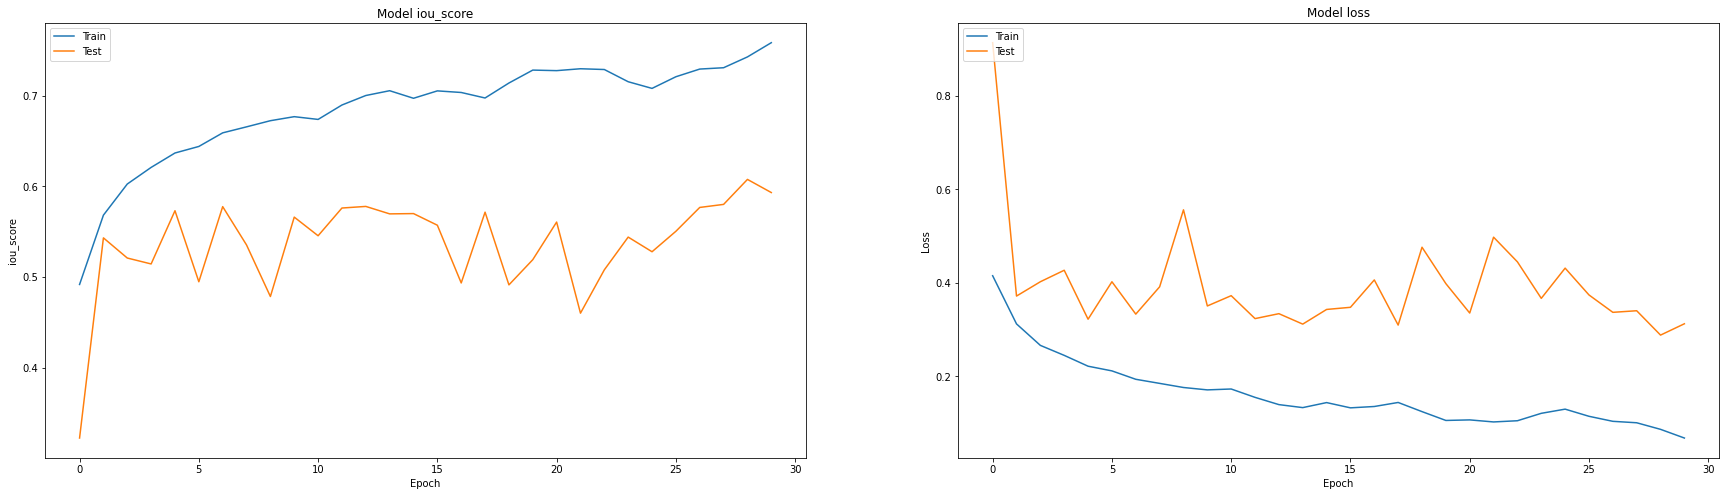

In [32]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 8))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 모델 평가

In [33]:
test_dataset = Dataset_multi(
    BnR_val_input_list, 
    Bnr_val_label_list, bnR_val_label_list, 
    classes=CLASSES,    
    augmentation=augmentations(),
#         preprocessing=get_preprocessing(preprocess_input)

)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [34]:

# load best weights
model.load_weights('/content/drive/MyDrive/SIA/colab_code/lhk/Lv2_BnR_Effb3_FPN_Aug_Act.h5')


In [35]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.29144
mean iou_score: 0.60008
mean f1-score: 0.71554


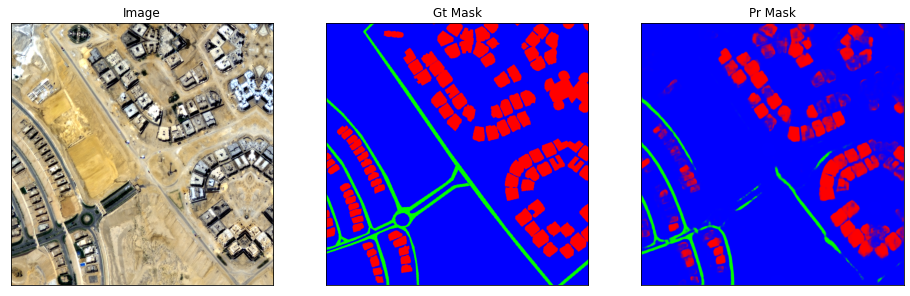

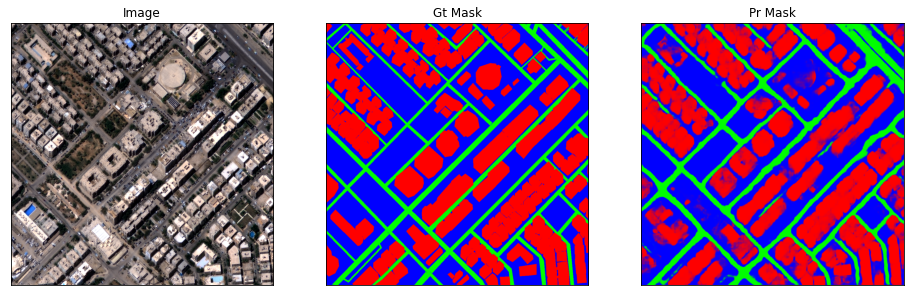

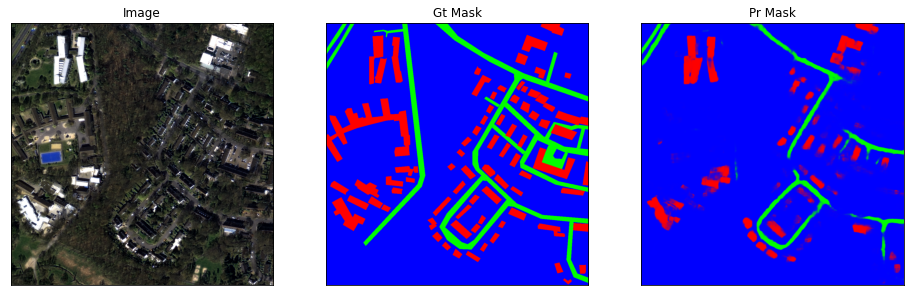

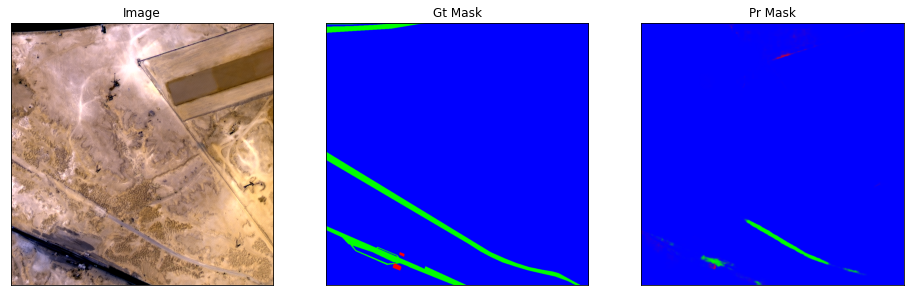

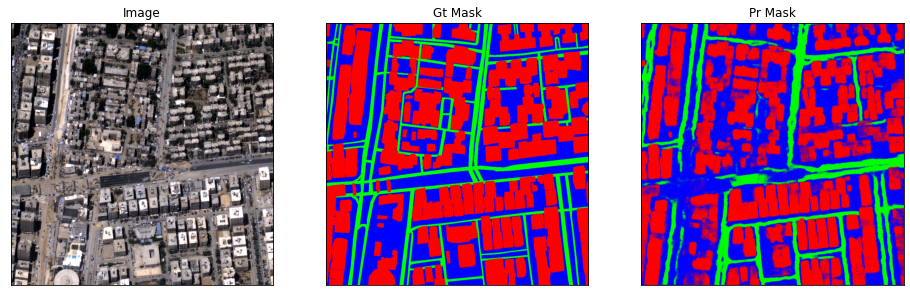

In [36]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

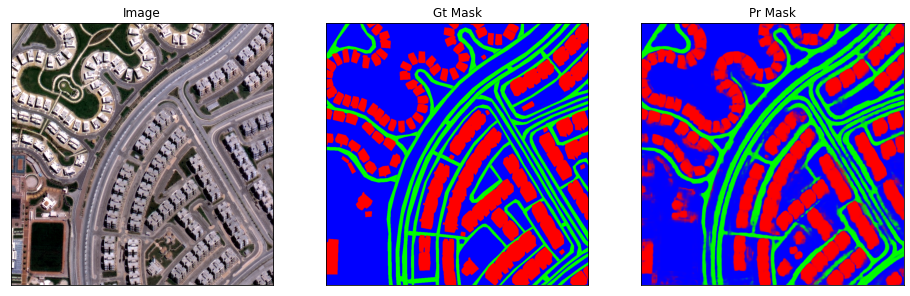

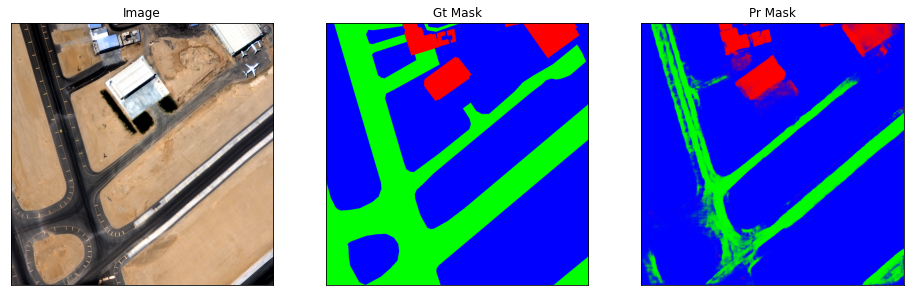

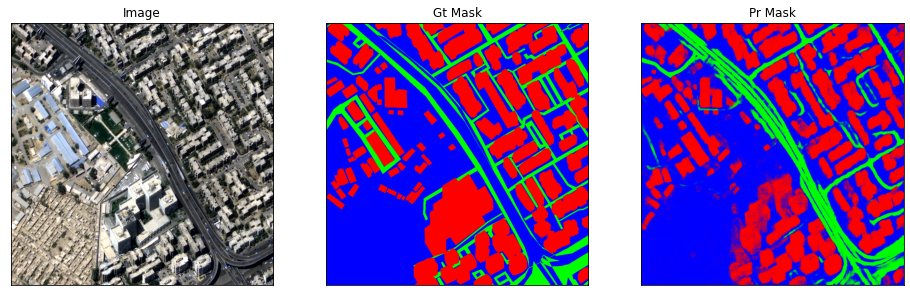

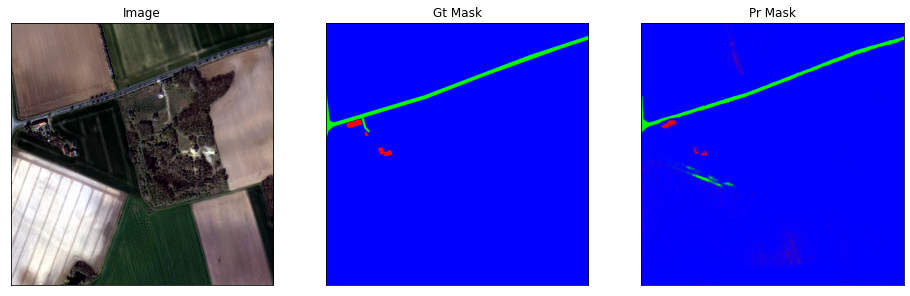

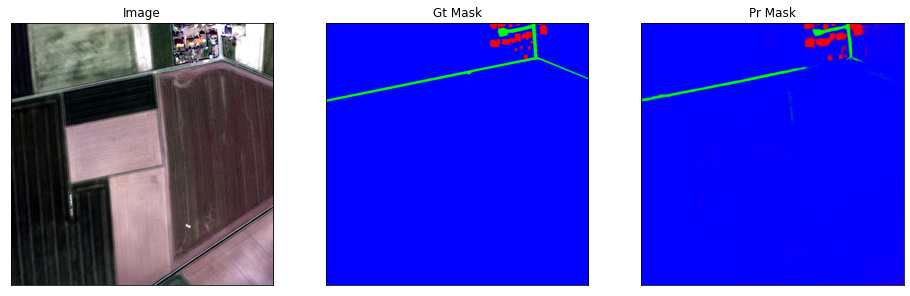

In [37]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )